In [1]:
# -*- coding: utf-8 -*-
# Packages ------------------------
import os
import sys
import shutil
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/Pedophysics_code')
sys.path.insert(0, 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey')
sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH

from pedophysics import predict, Soil

from FDEM import Initialize 
from FDEM. Initialize  import *

from scipy import constants
from utils.spatial_utils import utm_to_epsg, get_coincident
from utils.profile_utils import merge_layers, clip_profiles_to_max_depth, plot_profile, check_uniformity_and_interpolate, plot_combined_profiles
from utils.filter_utils import hampel_1d


from emagpy import Problem

# Check current working directory
print("Current Working Directory: ", os.getcwd())

Current Working Directory:  c:\Users\gmendoza\OneDrive - UGent\Documentos\PhD\EM case survey\EMI_survey_code


Data\calibrated\middelkerke_421S_calibrated_rECa.csv


<Figure size 1000x800 with 0 Axes>

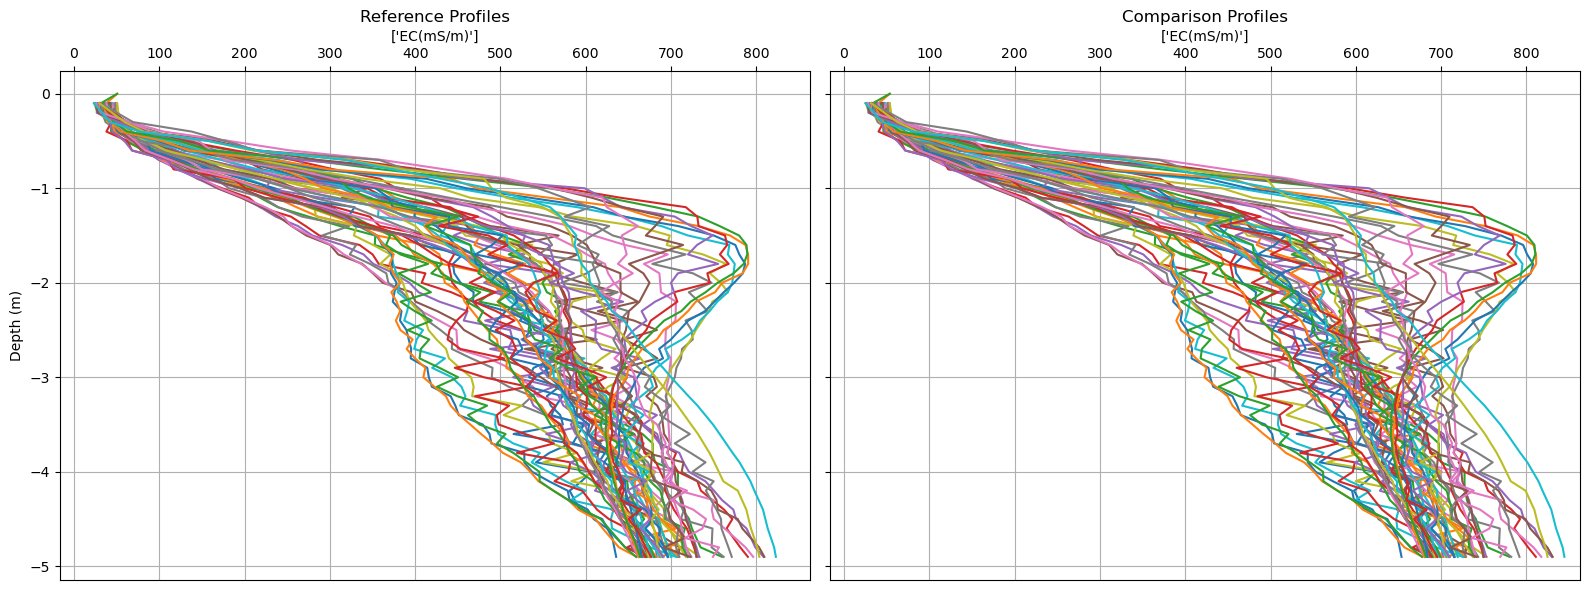

In [2]:
# User input
config = {}

s_site = 'M'; # P = Proefhoeve; M = Middelkerke

# Define input datatype and source folder
datafolder = 'Data' # data folder
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

config['fs_emp'] = 'FSeq' #'CS', 'FSlin' or 'FSeq'

config['reference_profile'] = 65 # ID of ERT (conductivity) profile to be used 
                                 #  to generate starting model
                                 # For proefhoeve nr 15 is used, for middelkerke 65

# remove profiles at transect edges
config['n_omit'] =  30 # number of EM profiles to exclude from the start
                       # and end of the transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available  


# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = False
config['interface'] = [0.3, 0.6, 1.0, 1.6] # n interfaces for n + 1 layers

# Sensor settings
config['instrument_code'] = 'Dualem-21HS'
config['instrument_height'] = 0.165
config['instrument_orientation'] = 'HCP'

config['remove_coil'] = True
config['coil_n'] = [4,5]

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'

cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder, f'{profile_prefix}-profiles.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_transect_calibrated_rECa.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_transect_calibrated_LIN.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_calibrated_rECa.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')

print(em_survey)
# Column names for emapgy input
emp_21HS = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1',	'HCP2.0', 'PRP2.1',
            'HCP0.5_inph', 'PRP0.6_inph', 'HCP1.0_inph',
            'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph'
            ]

emp_421S = ['HCP1.0', 'PRP1.1',	'HCP2.0', 'PRP2.1', 'HCP4.0', 'PRP4.1', 
            'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph',
            'HCP4.0_inph', 'PRP4.1_inph',
            ]

# Profile selection criteria
#   exclude profiles that don't reach the min_depth)
config['min_depth'] = -4.0 # minimum profile depth
config['max_depth'] = -6.0
config['surf_depth'] = 0

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)


if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                        instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

em_samples = get_coincident(em_survey,samples)

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Filter out profiles that don't reach min_depth (optional)
depth_filter = ert_p.groupby('ID').apply(lambda g: g['Z'].min() <= config['min_depth'])
filtered_profile_ids = depth_filter.index[depth_filter]
ert_p_depth_filtered = ert_p[ert_p['ID'].isin(filtered_profile_ids)]

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

selected_ids = unique_ids[config['n_omit']:-config['n_omit']] 
ert_p_selected = ert_p.loc[ert_p['ID'].isin(selected_ids)]

ert_final = clip_profiles_to_max_depth(ert_p_selected, config['max_depth'], 
                                       config['surf_depth'])

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# Reset the index without inserting it as a column
ert_final = ert_final.reset_index(drop=True)

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final[dataset_name] = ert_final[dataset_name]*1000
dc_corr[dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# Now group by 'ID' and find the minimum 'Z' value for each group
min_depths_per_profile = ert_final.groupby('ID')['Z'].max()

# Convert the Series to a DataFrame for better display and manipulation
min_depths_df = min_depths_per_profile.reset_index()
min_depths_df.columns = ['Profile ID', 'Minimum Depth']

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'Z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest
# Plotting combined profiles
plot_combined_profiles(ert_final, all_profiles_df, 
                       data_column, compare_name = data_column)

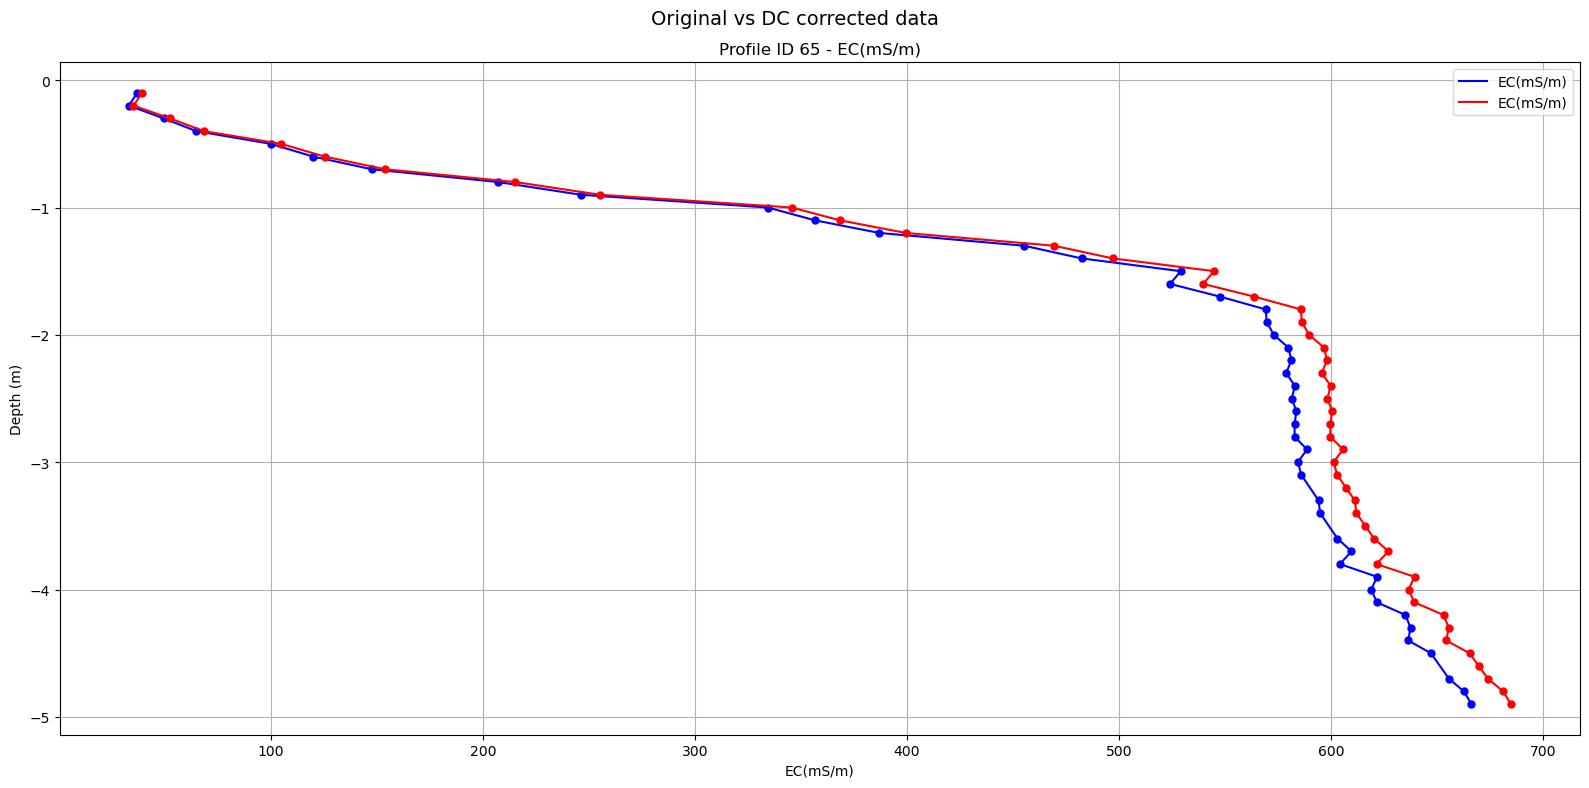

In [4]:
profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
else:
    merged_df = all_profiles_df

comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
else: 
    plot_title = 'Original vs DC corrected data'

plot_profile(ert_final, profile_id, dataset_name,compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', plot_title=plot_title) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])

        # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        #con = 1 / group[res_col].values
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)

        # Susceptibility is 0.0 for all layers
        sus = np.zeros(num_layers)

        # Create model instance
        M = Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

models = generate_forward_model_inputs(merged_df, 'ID', 'Z', 'EC(mS/m)')

In [ ]:
profile_data = merged_df[merged_df['ID'] == profile_id]

res_col = 'EC(mS/m)'
depth = 'Z'

thick = -profile_data[depth].iloc[1:]
con = profile_data[res_col].values/1000
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = FDEM.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
layers_interfaces= layers_interfaces
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, ax = plt.subplots(figsize=(5, 10))
# axs[0].plot(models[profile_id].con,-layers_interfaces)
# axs[1].plot((1/profile_data[dataset_name]),profile_data['z'])
ax.set_xlabel('EC [mS/m]')
ax.set_ylabel('depth [m]')
ax.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
ax.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
ax.legend()

mod_layers = thick
conductivities = con*1000

In [ ]:
config['n_omit']

In [ ]:
if em_intype == 'rec':
    em_input = em_rec.copy()
elif em_intype == 'survey':
    em_input = em_survey.copy()
else:
    em_input = em_lin.copy()
    
# Exclude the first and last n_omit profiles
unique_ids = em_input['p_ID'].unique()

selected_ids = unique_ids[config['n_omit']:-config['n_omit']] 
em_input = em_input.loc[em_input['p_ID'].isin(selected_ids)]

temp_dir = 'temp_emp' 
infile_name = 'infile.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

i = instrument.niter
n = 4
em_input.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_input.columns.values[n:n+i] = new_columns

em_input.to_csv(temp_file)

# transect inversion settings

t_rec = Problem()
t_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

t_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=conductivities
    # fixedDepths=startmodel['fixedDepths'],
    # fixedConds=startmodel['fixedConds']
    )
#print(np.flipud(mod_layers), conductivities)

shutil.rmtree(temp_dir)

if type(config['coil_n']) == list:
    config['coil_n'] = sorted(config['coil_n'])
    for i in enumerate(config['coil_n']):
        r_coil = t_rec.coils[(config['coil_n'][i[0]]-i[0])]
        # print(f'removing {r_coil}')
        t_rec.removeCoil(config['coil_n'][i[0]]-i[0])
else:
    t_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {t_rec.coils}')
# n = -2
# m = 1
# inc = 0.01
# n_alph = 10

# alphas = np.logspace(n,m,n_alph)
# t_rec.lcurve(alphas=alphas)

In [ ]:
warnings.filterwarnings('ignore')
t_rec.invert(forwardModel='FSeq', method='Gauss-Newton', alpha=0.07,regularization='l2')
t_rec.showOne2one()


In [ ]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------

csv_filename = profile_prefix + '_inverted_transect.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
t_rec.showResults(dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = t_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[t_rec.surveys[0].df[['x', 'y']].values, t_rec.models[0]]

# Creating the final dataframe with the desired column names
dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
dt_inv['pos'] = em_input['p_ID']
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(datafolder, csv_filename)
dt_inv.to_csv(outfile_transect)

In [ ]:
# Function to extract depth from column name
def extract_depth(col_name):
    if col_name.startswith('EC_'):
        return float(col_name.split('_')[1])
    return None

# Extracting depth values and sorting them
depth_cols = [col for col in dt_inv.columns if col.startswith('EC_')]
depths = [extract_depth(col) for col in depth_cols if col != 'EC_end']
depths.sort()

# Calculate depth for 'EC_end'
if depths:
    end_depth = depths[-1] + depths[0]
    depths.append(end_depth)

# Creating the new DataFrame
transformed_data = {
    'z': [],
    'EC': [],
    'easting': [],
    'northing': [],
    'ID': []
}

# Populating the new DataFrame
for _, row in dt_inv.iterrows():
    for depth, depth_col in zip(depths, depth_cols):
        transformed_data['z'].append(-depth)
        transformed_data['EC'].append(row[depth_col])
        transformed_data['easting'].append(row['x'])
        transformed_data['northing'].append(row['y'])
        transformed_data['ID'].append(row['pos'])

transformed_df = pd.DataFrame(transformed_data)

for i in transformed_df['ID'].unique():
    print(i)
    plot_profile(dc_corr, i, dataset_name,compare=True, compare_df = transformed_df, compare_name = 'EC',xlims=(0,200)) # def plot_profile(profile_df, profile_id, dataset_name, compare_df=None, compare_name=None):


In [ ]:
# em_survey = pd.read_csv(config['em_survey'], sep=',', header=0)

# em_input = em_survey.copy()

# temp_dir = 'temp_emp' 
# infile_name = 'infile.csv'
# os.makedirs(temp_dir, exist_ok=True)
# temp_file = os.path.join(temp_dir,infile_name)

# i = instrument.niter
# n = 4
# em_input.columns.values[n:n+i]

# if config['instrument_code'] == 'Dualem-21HS':
#     new_columns = emp_21HS
# else:
#     new_columns = emp_421S

# if len(new_columns) != i:
#     raise ValueError("The length of new_columns must be equal to the number of columns to rename")
# else:
#     em_input.columns.values[n:n+i] = new_columns



# em_input.to_csv(temp_file)

# # transect inversion settings

# s_rec = Problem()
# s_rec.createSurvey(temp_file)
# s_rec.rollingMean(window=12)
# #t_rec.removeCoil(0)
# #t_rec.removeCoil(0)
# s_rec.show(index=0, coil="all", vmin=None, vmax=None, dist=True)

# s_rec.setInit(
#     depths0=np.flipud(mod_layers),
#     conds0=conductivities
#     # fixedDepths=startmodel['fixedDepths'],
#     # fixedConds=startmodel['fixedConds']
#     )
# #print(np.flipud(mod_layers), conductivities)

# # depths_in = [0.1, 0.5, 0.8, 1.5]
# # t_rec.setInit(depths0=depths_in)
# shutil.rmtree(temp_dir)

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')
# s_rec.filterRange(vmin=5, vmax=220)
# s_rec.invert(forwardModel='FSlin', method='Gauss-Newton', alpha=0.07,regularization='l2')
# #t_rec.invert(forwardModel='CS', alpha=0.13, njobs=-1)
#s_rec.showOne2one()

In [ ]:
# # s_rec.showSlice(index=0, islice=3, vmin=None, vmax=None, cmap="viridis_r")
# # s_rec.showMisfit()
# s_rec.showOne2one()
# # s_rec.saveInvData(testdir)